<a href="https://colab.research.google.com/github/kartickgupta/shared-task-2021/blob/main/XLNet_base_resampled_cleaned_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Description:
1. Model Used : xlnet-base-cased
2. training Data : Cleaned 
3. Class Distribution : resampled
4. XLNet Layers = trainable
5. batch_size = 64

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Oct  5 15:28:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !pip install textaugment
# import nltk
# nltk.download('all')

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from google.colab import drive
# from textaugment import Wordnet, EDA, word2vec, Translate
# from nltk import WordNetLemmatizer
# from nltk.corpus import stopwords
import gensim
import re
import matplotlib.pyplot as plt
import seaborn as sns
# !pip3 install tensorflow_text
# import tensorflow_text
# !pip install -q tf-models-official
# !pip install -q -U tensorflow-text
# from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
# import tensorflow_hub as hub
# import tensorflow_text as tf_text
from tqdm import tqdm

In [4]:
!pip3 install transformers
!pip install sentencepiece

     |████████████████████████████████| 2.9 MB 7.4 MB/s 
     |████████████████████████████████| 636 kB 76.1 MB/s 
     |████████████████████████████████| 895 kB 87.5 MB/s 
     |████████████████████████████████| 3.3 MB 76.8 MB/s 
     |████████████████████████████████| 56 kB 6.4 MB/s 
     |████████████████████████████████| 109 kB 88.2 MB/s 
     |████████████████████████████████| 546 kB 79.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 7.3 MB/s 


In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
with open('/content/drive/MyDrive/Shared Task 2021/global-headline-only.csv', 'r') as f:
    df = pd.read_csv(f)

df.head()

,data_id,event_date,year,event_type,sub_event_type,region,country,location,notes,cleaned,lemmatized,stemmed
0,8378880,09-07-2021,2021,Explosions/Remote violence,Shelling/artillery/missile attack,Middle East,Syria,Arnaba,"On 9 July 2021, regime forces shelled Arnaba t...",regime forces shelled Arnaba town in Idleb cou...,regime force shelled arnaba town idleb country...,regim forc shell arnaba town idleb countrysid ...
1,8378881,09-07-2021,2021,Explosions/Remote violence,Shelling/artillery/missile attack,Middle East,Syria,Balyun,"On 9 July 2021, regime forces shelled Balyun t...",regime forces shelled Balyun town and its vici...,regime force shelled balyun town vicinity idle...,regim forc shell balyun town vicin idleb count...
2,8381441,09-07-2021,2021,Protests,Peaceful protest,East Asia,South Korea,Jinju,"On 9 July 2021, local veterans' organizations,...",local veterans organizations including the Kor...,local veteran organization including korean wa...,local veteran organ includ korean war veteran ...
3,8383746,09-07-2021,2021,Riots,Violent demonstration,South Asia,Pakistan,Larkana,"On 9 July 2021, prisoners held a demonstration...",prisoners held a demonstration and set wood an...,prisoner held demonstration set wood clothes f...,prison held demonstr set wood cloth fire larka...
4,8381699,09-07-2021,2021,Violence against civilians,Attack,Southeast Asia,Myanmar,Hpa Yar Gyi,"On 9 July 2021, in Hpa Yar Gyi village (Thongw...",in Hpa Yar Gyi village the village administra...,hpa yar gyi village village administrator shot...,hpa yar gyi villag villag administr shot three...


In [7]:
correct_format = ['ABDUCT_DISSAP',
'AGREEMENT',
'AIR_STRIKE',
'ARMED_CLASH',
'ARREST',
'ART_MISS_ATTACK',
'ATTACK',
'CHANGE_TO_GROUP_ACT',
'CHEM_WEAP',
'DISR_WEAP',
'FORCE_AGAINST_PROTEST',
'GOV_REGAINS_TERIT',
'GRENADE',
'HQ_ESTABLISHED',
'MOB_VIOL',
'NON_STATE_ACTOR_OVERTAKES_TER',
'NON_VIOL_TERRIT_TRANSFER',
'OTHER',
'PEACE_PROTEST',
'PROPERTY_DISTRUCT',
'PROTEST_WITH_INTER',
'REM_EXPLOS',
'SEX_VIOL',
'SUIC_BOMB',
'VIOL_DEMONSTR']

In [8]:
correct_format_dict = {'Abduction/forced disappearance':'ABDUCT_DISSAP',
                       'Agreement': 'AGREEMENT',
                        'Air/drone strike' : 'AIR_STRIKE',
                         'Armed clash' : 'ARMED_CLASH',
                       'Arrests' : 'ARREST',
                       'Attack' : 'ATTACK',
                       'Change to group/activity' : 'CHANGE_TO_GROUP_ACT',
                       'Chemical weapon' : 'CHEM_WEAP',
                       'Disrupted weapons use' : 'DISR_WEAP',
                       'Excessive force against protesters' : 'FORCE_AGAINST_PROTEST',
                       'Government regains territory' : 'GOV_REGAINS_TERIT',
                       'Grenade' : 'GRENADE',
                        'Headquarters or base established' : 'HQ_ESTABLISHED',
                       'Looting/property destruction' : 'PROPERTY_DISTRUCT',
                       'Mob violence' : 'MOB_VIOL',
                       'Non-state actor overtakes territory' : 'NON_STATE_ACTOR_OVERTAKES_TER',
                       'Non-violent transfer of territory' : 'NON_VIOL_TERRIT_TRANSFER',
                       'Other' : 'OTHER',
                        'Peaceful protest' : 'PEACE_PROTEST',
                       'Protest with intervention' : 'PROTEST_WITH_INTER',
                       'Remote explosive/landmine/IED' : 'REM_EXPLOS',
                       'Sexual violence' : 'SEX_VIOL',
                       'Shelling/artillery/missile attack' : 'ART_MISS_ATTACK',
                       'Suicide bomb' : 'SUIC_BOMB',
                        'Violent demonstration' : 'VIOL_DEMONSTR'
                       }

In [9]:
correct_format_dict

{'Abduction/forced disappearance': 'ABDUCT_DISSAP',
 'Agreement': 'AGREEMENT',
 'Air/drone strike': 'AIR_STRIKE',
 'Armed clash': 'ARMED_CLASH',
 'Arrests': 'ARREST',
 'Attack': 'ATTACK',
 'Change to group/activity': 'CHANGE_TO_GROUP_ACT',
 'Chemical weapon': 'CHEM_WEAP',
 'Disrupted weapons use': 'DISR_WEAP',
 'Excessive force against protesters': 'FORCE_AGAINST_PROTEST',
 'Government regains territory': 'GOV_REGAINS_TERIT',
 'Grenade': 'GRENADE',
 'Headquarters or base established': 'HQ_ESTABLISHED',
 'Looting/property destruction': 'PROPERTY_DISTRUCT',
 'Mob violence': 'MOB_VIOL',
 'Non-state actor overtakes territory': 'NON_STATE_ACTOR_OVERTAKES_TER',
 'Non-violent transfer of territory': 'NON_VIOL_TERRIT_TRANSFER',
 'Other': 'OTHER',
 'Peaceful protest': 'PEACE_PROTEST',
 'Protest with intervention': 'PROTEST_WITH_INTER',
 'Remote explosive/landmine/IED': 'REM_EXPLOS',
 'Sexual violence': 'SEX_VIOL',
 'Shelling/artillery/missile attack': 'ART_MISS_ATTACK',
 'Suicide bomb': 'SUIC_B

In [10]:
def correct_format(text):
    correct_label = correct_format_dict[text]
    return correct_label

df['sub_event_type'] = df['sub_event_type'].apply(correct_format)

In [11]:
df.sub_event_type.value_counts()

PEACE_PROTEST                    329399
ARMED_CLASH                      239828
ATTACK                           132202
ART_MISS_ATTACK                   64743
MOB_VIOL                          42079
VIOL_DEMONSTR                     41003
AIR_STRIKE                        34020
PROTEST_WITH_INTER                31784
REM_EXPLOS                        30620
PROPERTY_DISTRUCT                 24315
ABDUCT_DISSAP                     14624
ARREST                             8668
CHANGE_TO_GROUP_ACT                7925
DISR_WEAP                          7499
GOV_REGAINS_TERIT                  6148
OTHER                              5353
FORCE_AGAINST_PROTEST              3098
GRENADE                            2948
NON_STATE_ACTOR_OVERTAKES_TER      2670
SEX_VIOL                           2196
AGREEMENT                          1460
NON_VIOL_TERRIT_TRANSFER            989
SUIC_BOMB                           635
HQ_ESTABLISHED                      311
CHEM_WEAP                            10


In [12]:
df.drop_duplicates(['lemmatized']).sub_event_type.value_counts()

PEACE_PROTEST                    305383
ARMED_CLASH                       96231
ATTACK                            65363
ART_MISS_ATTACK                   33279
VIOL_DEMONSTR                     24574
MOB_VIOL                          21098
AIR_STRIKE                        18620
REM_EXPLOS                        16110
PROTEST_WITH_INTER                15003
PROPERTY_DISTRUCT                 12036
ABDUCT_DISSAP                      7214
CHANGE_TO_GROUP_ACT                7098
ARREST                             4238
DISR_WEAP                          3866
OTHER                              3698
GOV_REGAINS_TERIT                  2424
GRENADE                            1530
FORCE_AGAINST_PROTEST              1520
NON_STATE_ACTOR_OVERTAKES_TER      1198
SEX_VIOL                           1027
AGREEMENT                           692
NON_VIOL_TERRIT_TRANSFER            512
SUIC_BOMB                           319
HQ_ESTABLISHED                      291
CHEM_WEAP                             4


In [13]:
event_types_dict = {}
for num, name in enumerate(list(df['sub_event_type'].unique())):
    event_types_dict[name] = num
    # print(name, " : ", num)

event_types_dict

event_types_dict_inverse = {k:v for v,k in event_types_dict.items()}
print(event_types_dict)
print( event_types_dict_inverse)

{'ART_MISS_ATTACK': 0, 'PEACE_PROTEST': 1, 'VIOL_DEMONSTR': 2, 'ATTACK': 3, 'AIR_STRIKE': 4, 'ARMED_CLASH': 5, 'MOB_VIOL': 6, 'PROTEST_WITH_INTER': 7, 'FORCE_AGAINST_PROTEST': 8, 'PROPERTY_DISTRUCT': 9, 'OTHER': 10, 'REM_EXPLOS': 11, 'GOV_REGAINS_TERIT': 12, 'ABDUCT_DISSAP': 13, 'CHANGE_TO_GROUP_ACT': 14, 'NON_STATE_ACTOR_OVERTAKES_TER': 15, 'ARREST': 16, 'SEX_VIOL': 17, 'DISR_WEAP': 18, 'NON_VIOL_TERRIT_TRANSFER': 19, 'GRENADE': 20, 'HQ_ESTABLISHED': 21, 'SUIC_BOMB': 22, 'AGREEMENT': 23, 'CHEM_WEAP': 24}
{0: 'ART_MISS_ATTACK', 1: 'PEACE_PROTEST', 2: 'VIOL_DEMONSTR', 3: 'ATTACK', 4: 'AIR_STRIKE', 5: 'ARMED_CLASH', 6: 'MOB_VIOL', 7: 'PROTEST_WITH_INTER', 8: 'FORCE_AGAINST_PROTEST', 9: 'PROPERTY_DISTRUCT', 10: 'OTHER', 11: 'REM_EXPLOS', 12: 'GOV_REGAINS_TERIT', 13: 'ABDUCT_DISSAP', 14: 'CHANGE_TO_GROUP_ACT', 15: 'NON_STATE_ACTOR_OVERTAKES_TER', 16: 'ARREST', 17: 'SEX_VIOL', 18: 'DISR_WEAP', 19: 'NON_VIOL_TERRIT_TRANSFER', 20: 'GRENADE', 21: 'HQ_ESTABLISHED', 22: 'SUIC_BOMB', 23: 'AGREEME

In [14]:
dict_list = list(event_types_dict.keys())

In [15]:
def text_to_numerical_category(name):
    num = event_types_dict[name]
    return num

# print(text_to_numerical_category('Peaceful protest'))
df['labels'] = df['sub_event_type'].apply(text_to_numerical_category)

In [16]:
df.drop(columns=['data_id', 'event_date', 'year','event_type','region','country', 'location',	'notes','lemmatized', 'stemmed'	], inplace=True)

In [17]:
df.head()

,sub_event_type,cleaned,labels
0,ART_MISS_ATTACK,regime forces shelled Arnaba town in Idleb cou...,0
1,ART_MISS_ATTACK,regime forces shelled Balyun town and its vici...,0
2,PEACE_PROTEST,local veterans organizations including the Kor...,1
3,VIOL_DEMONSTR,prisoners held a demonstration and set wood an...,2
4,ATTACK,in Hpa Yar Gyi village the village administra...,3


## Handling Imbalanced Dataset

In [18]:
from sklearn.utils import shuffle

lemm = []
labels = []
THRESH_1 = 20000
THRESH_2 = 10000
THRESH_3 = 1000

for group in df.sub_event_type.unique():
    # Having More Than 20K
    if len(df.groupby('sub_event_type').get_group(group).cleaned.unique()) > THRESH_1:
        lemm += (list(shuffle(df.groupby('sub_event_type').get_group(group).cleaned.unique()))[:THRESH_1])
        labels += ([group]*THRESH_1)
     # Having Unique b/w 20K and 10K - Take top 20K from all
    elif len(df.groupby('sub_event_type').get_group(group).cleaned.unique()) < THRESH_1 and len(df.groupby('sub_event_type').get_group(group).cleaned.unique()) > THRESH_2:
       lemm += (list(shuffle(df.groupby('sub_event_type').get_group(group).cleaned))[:THRESH_1])
       labels += ([group]*THRESH_1)
    # Having b/w 20K and 5K - take all
    elif len(df.groupby('sub_event_type').get_group(group).cleaned) < 20000 and len(df.groupby('sub_event_type').get_group(group).cleaned) > 5000:
       lemm += list(shuffle(df.groupby('sub_event_type').get_group(group).cleaned))
       labels += ([group]*len(list(shuffle(df.groupby('sub_event_type').get_group(group).cleaned))))
     # Having Less Than 1K - Multipy by 6
    elif len(df.groupby('sub_event_type').get_group(group).cleaned) < THRESH_3:
        for i in range(6):
            lemm += list(shuffle(df.groupby('sub_event_type').get_group(group).cleaned))
            labels += ([group]*len(list(shuffle(df.groupby('sub_event_type').get_group(group).cleaned))))
    # Remaining - Multiply by 2
    else:
         for i in range(2):
            lemm += list(shuffle(df.groupby('sub_event_type').get_group(group).cleaned))
            labels += ([group]*len(list(shuffle(df.groupby('sub_event_type').get_group(group).cleaned))))


In [19]:
len(lemm)

286631

In [20]:
len(labels)

286631

In [21]:
balanced_df = pd.DataFrame({'Text' : lemm, 'Labels': labels})

In [22]:
balanced_df.head()

,Text,Labels
0,March the OSCE SMM observed a total of explosi...,ART_MISS_ATTACK
1,rebel fighters fired GRAD and How rockets at r...,ART_MISS_ATTACK
2,June regime forces shelled Hazarin in souther...,ART_MISS_ATTACK
3,November the NAF rebel forces fired antiaircra...,ART_MISS_ATTACK
4,April the OSCE SMM observed a total of explosi...,ART_MISS_ATTACK


In [23]:
event_types_dict_new = {}
for num, name in enumerate(list(balanced_df.Labels.unique())):
    event_types_dict_new[name] = num
    # print(name, " : ", num)

event_types_dict_new

event_types_dict_inverse_new = {k:v for v,k in event_types_dict_new.items()}
print(event_types_dict_new)
print( event_types_dict_inverse_new)

{'ART_MISS_ATTACK': 0, 'PEACE_PROTEST': 1, 'VIOL_DEMONSTR': 2, 'ATTACK': 3, 'AIR_STRIKE': 4, 'ARMED_CLASH': 5, 'MOB_VIOL': 6, 'PROTEST_WITH_INTER': 7, 'FORCE_AGAINST_PROTEST': 8, 'PROPERTY_DISTRUCT': 9, 'OTHER': 10, 'REM_EXPLOS': 11, 'GOV_REGAINS_TERIT': 12, 'ABDUCT_DISSAP': 13, 'CHANGE_TO_GROUP_ACT': 14, 'NON_STATE_ACTOR_OVERTAKES_TER': 15, 'ARREST': 16, 'SEX_VIOL': 17, 'DISR_WEAP': 18, 'NON_VIOL_TERRIT_TRANSFER': 19, 'GRENADE': 20, 'HQ_ESTABLISHED': 21, 'SUIC_BOMB': 22, 'AGREEMENT': 23, 'CHEM_WEAP': 24}
{0: 'ART_MISS_ATTACK', 1: 'PEACE_PROTEST', 2: 'VIOL_DEMONSTR', 3: 'ATTACK', 4: 'AIR_STRIKE', 5: 'ARMED_CLASH', 6: 'MOB_VIOL', 7: 'PROTEST_WITH_INTER', 8: 'FORCE_AGAINST_PROTEST', 9: 'PROPERTY_DISTRUCT', 10: 'OTHER', 11: 'REM_EXPLOS', 12: 'GOV_REGAINS_TERIT', 13: 'ABDUCT_DISSAP', 14: 'CHANGE_TO_GROUP_ACT', 15: 'NON_STATE_ACTOR_OVERTAKES_TER', 16: 'ARREST', 17: 'SEX_VIOL', 18: 'DISR_WEAP', 19: 'NON_VIOL_TERRIT_TRANSFER', 20: 'GRENADE', 21: 'HQ_ESTABLISHED', 22: 'SUIC_BOMB', 23: 'AGREEME

## Event Frequency comparison w/ Original and Augmented Data.

In [24]:
df.sub_event_type.value_counts()

PEACE_PROTEST                    329399
ARMED_CLASH                      239828
ATTACK                           132202
ART_MISS_ATTACK                   64743
MOB_VIOL                          42079
VIOL_DEMONSTR                     41003
AIR_STRIKE                        34020
PROTEST_WITH_INTER                31784
REM_EXPLOS                        30620
PROPERTY_DISTRUCT                 24315
ABDUCT_DISSAP                     14624
ARREST                             8668
CHANGE_TO_GROUP_ACT                7925
DISR_WEAP                          7499
GOV_REGAINS_TERIT                  6148
OTHER                              5353
FORCE_AGAINST_PROTEST              3098
GRENADE                            2948
NON_STATE_ACTOR_OVERTAKES_TER      2670
SEX_VIOL                           2196
AGREEMENT                          1460
NON_VIOL_TERRIT_TRANSFER            989
SUIC_BOMB                           635
HQ_ESTABLISHED                      311
CHEM_WEAP                            10


In [25]:
balanced_df.Labels.value_counts()

REM_EXPLOS                       20000
ARMED_CLASH                      20000
MOB_VIOL                         20000
AIR_STRIKE                       20000
PROTEST_WITH_INTER               20000
ATTACK                           20000
PEACE_PROTEST                    20000
VIOL_DEMONSTR                    20000
PROPERTY_DISTRUCT                20000
ART_MISS_ATTACK                  20000
ABDUCT_DISSAP                    14624
ARREST                            8668
CHANGE_TO_GROUP_ACT               7925
DISR_WEAP                         7499
FORCE_AGAINST_PROTEST             6196
GOV_REGAINS_TERIT                 6148
NON_VIOL_TERRIT_TRANSFER          5934
GRENADE                           5896
OTHER                             5353
NON_STATE_ACTOR_OVERTAKES_TER     5340
SEX_VIOL                          4392
SUIC_BOMB                         3810
AGREEMENT                         2920
HQ_ESTABLISHED                    1866
CHEM_WEAP                           60
Name: Labels, dtype: int6

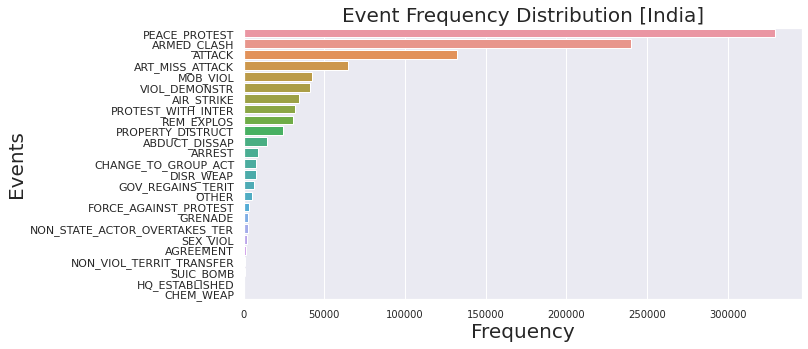

In [26]:
sns.set_theme(style="darkgrid")
x = df['sub_event_type'].value_counts()
y = x.index
plt.figure(figsize=(10, 5))
g = sns.barplot(x=x, y=y)
plt.title("Event Frequency Distribution [India]", fontsize=20)
plt.ylabel('Events', fontsize= 20)
plt.yticks(fontsize=11)
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=10)
plt.show()

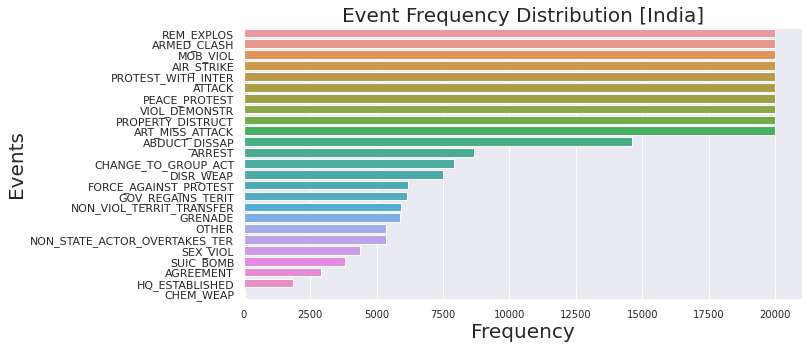

In [27]:
sns.set_theme(style="darkgrid")
x = balanced_df.Labels.value_counts()
y = x.index
plt.figure(figsize=(10, 5))
g = sns.barplot(x=x, y=y)
plt.title("Event Frequency Distribution [India]", fontsize=20)
plt.ylabel('Events', fontsize= 20)
plt.yticks(fontsize=11)
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=10)
plt.show()

In [28]:
balanced_df['NumLabel'] = balanced_df.Labels.apply(text_to_numerical_category)

In [29]:
balanced_df.head()

,Text,Labels,NumLabel
0,March the OSCE SMM observed a total of explosi...,ART_MISS_ATTACK,0
1,rebel fighters fired GRAD and How rockets at r...,ART_MISS_ATTACK,0
2,June regime forces shelled Hazarin in souther...,ART_MISS_ATTACK,0
3,November the NAF rebel forces fired antiaircra...,ART_MISS_ATTACK,0
4,April the OSCE SMM observed a total of explosi...,ART_MISS_ATTACK,0


# XLNet

In [30]:
max_classes = len(balanced_df.Labels.unique())
max_length = 128

In [31]:
from transformers import AutoTokenizer, TFXLNetModel

# Same as before

checkpoint = "xlnet-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, max_length=max_length)

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

## Hyperparametrs

In [32]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

EPOCHS = 3
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
batch_size = 64

# num_train_steps =  len((balanced_df.NumLabel) // batch_size) * EPOCHS
# lr_scheduler = PolynomialDecay(initial_learning_rate=5e-5,
#                                end_learning_rate=0.,
#                                decay_steps=num_train_steps
#                                )

from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=5e-5)

## Tokenization

In [33]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
result_df = shuffle(balanced_df)

In [34]:
result_df

,Text,Labels,NumLabel
64790,a police officer beat a farmer to death at a c...,ATTACK,3
251120,October In response to a planned protest in Do...,ARREST,16
286324,July in Koui at least RRR fighters have disarm...,AGREEMENT,23
25950,around persons demonstrated in SaintDenis They...,PEACE_PROTEST,1
243745,Around Eritrean soldiers reportedly took cont...,NON_STATE_ACTOR_OVERTAKES_TER,15
...,...,...,...
266972,Regime forces regained control of Ein Eltineh ...,NON_VIOL_TERRIT_TRANSFER,19
200117,unknown militants detonated an explosive devic...,REM_EXPLOS,11
81,November the OSCE SMM observed a total of expl...,ART_MISS_ATTACK,0
83262,or before south of Sheikh Zuweiyid Egyptian ...,AIR_STRIKE,4


In [35]:
result_df.to_csv('resampled-training-data.csv', index=True)

In [36]:
# result_df = pd.read_csv('/content/drive/MyDrive/Shared-Task-2021/resampled-training-data-ggod.csv', index_col=0)
# result_df

### Train-Test-Split

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(result_df.Text, result_df.NumLabel, test_size = 0.1, random_state = 42, stratify =result_df.NumLabel)

### Label Encoding

In [38]:
max_classes = len(balanced_df.Labels.unique())
print(max_classes)

25


In [39]:
%%time
encoded_labels_train = to_categorical(Y_train, num_classes=max_classes)
encoded_labels_test = to_categorical(Y_test, num_classes=max_classes)

CPU times: user 10.7 ms, sys: 0 ns, total: 10.7 ms
Wall time: 10.2 ms


### Input-Tokenization

#### Defining XLNet Tokenizer

In [40]:
def XLNet_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []
  

  for i in tqdm(range(len(data))):
      encoded = tokenizer.encode_plus(
        
        data[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        return_attention_mask=True,
        
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

In [41]:
%%time
# train_inputs,train_attention_masks = XLNet_encode(list(X_train), max_length)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [42]:
# test_inputs,test_attention_masks = XLNet_encode(list(X_test), max_length)

In [43]:
def get_inputs(tweets, tokenizer, max_len=120):
    """ Gets tensors from text using the tokenizer provided"""
    inps = [tokenizer.encode_plus(t, max_length=max_len, pad_to_max_length=True, add_special_tokens=True) for t in tweets]
    inp_tok = np.array([a['input_ids'] for a in inps])
    ids = np.array([a['attention_mask'] for a in inps])
    segments = np.array([a['token_type_ids'] for a in inps])
    return inp_tok, ids, segments

In [44]:
%%time
train_inp_tok, train_attention_masks, segments = get_inputs(X_train, tokenizer)
test_inp_tok, test_attention_masks, segments = get_inputs(X_test, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


CPU times: user 1min 7s, sys: 4.32 s, total: 1min 11s
Wall time: 1min 11s


In [45]:
print(train_inp_tok.shape, test_inp_tok.shape)

(257967, 120) (28664, 120)


In [46]:
print(f'Number of Samples in Training Set : {len(X_train)} Number of Samples in Validation Set: {len(X_test)} ')

Number of Samples in Training Set : 257967 Number of Samples in Validation Set: 28664 


## Custom Callbacks

In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
!mkdir checkpoints

MyCheckpoint = ModelCheckpoint('XLNet-base.h5',
                               monitor = 'val_categorical_accuracy',
                               verbose = 1,
                               save_best_only = True,
                               mode='auto',
                               save_weights_only = True)

MyEarlyStopping = EarlyStopping(patience =1,
                                monitor='val_categorical_accuracy',
                                restore_best_weights = True,
                                verbose = 1)

import os
os.path.exists('/content/checkpoints')

True

## Class Weight Balancing

In [48]:
from sklearn.utils import class_weight
class_weights_array = class_weight.compute_class_weight('balanced'
                                               ,np.unique(balanced_df.NumLabel)
                                               ,balanced_df.NumLabel)

class_weights_array

array([  0.573262  ,   0.573262  ,   0.573262  ,   0.573262  ,
         0.573262  ,   0.573262  ,   0.573262  ,   0.573262  ,
         1.85042608,   0.573262  ,   2.14183449,   0.573262  ,
         1.86487313,   0.78400164,   1.44671798,   2.14704869,
         1.32270881,   2.6104827 ,   1.52890252,   1.93212673,
         1.94457938,   6.14428725,   3.00924934,   3.92645205,
       191.08733333])

In [49]:
class_weights = {i : class_weights_array[i] for i in range(len(class_weights_array))}
class_weights

{0: 0.573262,
 1: 0.573262,
 2: 0.573262,
 3: 0.573262,
 4: 0.573262,
 5: 0.573262,
 6: 0.573262,
 7: 0.573262,
 8: 1.8504260813428017,
 9: 0.573262,
 10: 2.141834485335326,
 11: 0.573262,
 12: 1.8648731294729994,
 13: 0.7840016411378555,
 14: 1.4467179810725552,
 15: 2.1470486891385767,
 16: 1.322708814028611,
 17: 2.6104826958105645,
 18: 1.528902520336045,
 19: 1.9321267273340075,
 20: 1.9445793758480325,
 21: 6.144287245444802,
 22: 3.009249343832021,
 23: 3.9264520547945208,
 24: 191.08733333333333}

## Building Model

### Defining Model Metrics

In [50]:
# !pip install tensorflow_addons
# import tensorflow_addons as tfa

# macro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='macro')
# micro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='micro')
# weighted_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='weighted')
precision = tf.metrics.Precision()
recall = tf.metrics.Recall()
categorical_accuracry = tf.metrics.CategoricalAccuracy()

class F1_metric(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        # Initialize our metric by initializing the two metrics it's based on:
        # Precision and Recall
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update our metric by updating the two metrics it's based on
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

    def result(self):
        # To get the F1 result, we compute the harmonic mean of the current
        # precision and recall
        return 2 / ((1 / self.precision.result()) + (1 / self.recall.result())) 

F1Score = F1_metric()
metrics = [categorical_accuracry, F1Score]


### Custom Model Creation

In [51]:
def create_model(xlnet_model):
  input_ids = tf.keras.Input(shape=(max_length,),dtype='int32')

  attention_masks = tf.keras.Input(shape=(max_length,),dtype='int32')
  
#   output = xlnet_model([input_ids,attention_masks])
  output = xlnet_model(input_ids)
  output = output[0]
  output = tf.squeeze(output[:, -1:, :], axis=1)
  
#   output = tf.keras.layers.Dense(128,activation='relu',)(output)
#   output = tf.keras.layers.Dropout(0.2)(output)
#   output = tf.keras.layers.BatchNormalization()(output)

#   output = tf.keras.layers.Dense(64,activation='relu',)(output)
#   output = tf.keras.layers.Dropout(0.2)(output)
#   output = tf.keras.layers.BatchNormalization()(output)

  output = tf.keras.layers.Dense(32,activation='relu')(output)
  output = tf.keras.layers.Dropout(0.2)(output)
  
  output = tf.keras.layers.Dense(units=max_classes,activation='softmax')(output)
  model = tf.keras.models.Model(inputs = input_ids,outputs = output)
  model.compile(optimizer= opt,
              loss= loss,
              metrics = metrics)
  return model

In [52]:
def create_xlnet(mname):
    """ Creates the model. It is composed of the XLNet main block and then
    a classification head its added
    """
    # Define token ids as inputs
    word_inputs = tf.keras.Input(shape=(120,), name='word_inputs', dtype='int32')
    attention_masks = tf.keras.Input(shape=(120,),dtype='int32')
    # Call XLNet model
    xlnet = TFXLNetModel.from_pretrained(mname)
    xlnet_encodings = xlnet(word_inputs, attention_masks)[0]

    # CLASSIFICATION HEAD 
    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    # Apply dropout for regularization
    doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
    # Final output 
    outputs = tf.keras.layers.Dense(units=max_classes,activation='softmax')(doc_encoding)

    # Compile model
    model = tf.keras.Model(inputs=[word_inputs, attention_masks], outputs=[outputs])
    model.compile(optimizer= opt,
              loss= loss,
              metrics = metrics)

    return model

## Model Summary

In [53]:
from transformers import TFXLNetModel
xlnet_model = TFXLNetModel.from_pretrained(checkpoint)
# from transformers import TFAutoModelForSequenceClassification
# model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=max_classes)

model = create_xlnet(checkpoint)
# model.layers[2].trainable = False
model.summary()

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel fro

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_inputs (InputLayer)        [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 120)]        0                                            
__________________________________________________________________________________________________
tfxl_net_model_1 (TFXLNetModel) TFXLNetModelOutput(l 116718336   word_inputs[0][0]                
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 1, 768)       0           tfxl_net_model_1[0][0]       

## Model Training

In [54]:
%%time
history = model.fit([train_inp_tok, train_attention_masks], encoded_labels_train, 
                    validation_data=([test_inp_tok, test_attention_masks], encoded_labels_test),
                    epochs = EPOCHS,
                    batch_size = 64,
                    verbose = 1,
                    class_weight=class_weights,
                    callbacks = [MyCheckpoint, MyEarlyStopping]
                    )

Epoch 1/3
4031/4031 [==============================] - 4570s 1s/step - loss: 0.4128 - categorical_accuracy: 0.8746 - f1_score: 0.8805 - val_loss: 0.2299 - val_categorical_accuracy: 0.9358 - val_f1_score: 0.9359

Epoch 00001: val_categorical_accuracy improved from -inf to 0.93577, saving model to XLNet-base.h5
Epoch 2/3
4031/4031 [==============================] - 4553s 1s/step - loss: 0.2313 - categorical_accuracy: 0.9334 - f1_score: 0.9342 - val_loss: 0.2100 - val_categorical_accuracy: 0.9459 - val_f1_score: 0.9462

Epoch 00002: val_categorical_accuracy improved from 0.93577 to 0.94589, saving model to XLNet-base.h5
Epoch 3/3
 185/4031 [>.............................] - ETA: 1:09:54 - loss: 0.1221 - categorical_accuracy: 0.9571 - f1_score: 0.9576

KeyboardInterrupt: ignored

In [55]:
import matplotlib.pyplot as plt 
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "categorical_accuracy")
plot_graphs(history, "f1_score")
plot_graphs(history, 'loss')


NameError: ignored

In [ ]:
# model.save('BERT-Model.h5')

# Epoch - 2

In [56]:
test_file = pd.read_csv('/content/drive/MyDrive/Shared Task 2021/test-set-with-labels-cleaned.txt', index_col=0)

In [57]:
test_file.head()

,EventSnippet,SubType,processed,lemmatized
id,,,,
1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,the us warplanes pounded the village of kashka...,u warplane pounded village kashkash southern p...
3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officers brutally attacked and injured a peace...,officer brutally attacked injured peaceful stu...
4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isis fighters recaptured the village of kashma...,isi fighter recaptured village kashma syrian a...
5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike pence said thursday that t...,vice-president mike penny said thursday mainly...
6,A helicopter on Thursday is said to have dropp...,CHEM_WEAP,a helicopter thursday is said to have dropped ...,helicopter thursday said dropped container tox...


## For Cleaned Text

In [64]:
final_test_inputs, final_test_attention_masks, segments = get_inputs(test_file.processed, tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [65]:
y_preds = np.argmax(model.predict([final_test_inputs, final_test_attention_masks]), axis=1)

In [66]:
y_preds

array([ 4,  8, 12, 23, 24, 10,  1, 12, 12, 14, 10, 10,  1, 14, 20,  2, 18,
        8,  6,  3,  5,  0, 20,  3, 10,  6,  2, 18,  6, 18,  5,  0, 20, 14,
       23, 20, 23, 22, 23, 16, 11,  0, 22, 18, 18,  5, 19,  8,  3, 24, 12,
       24, 15, 11, 19, 16, 19, 10, 24, 18, 10, 11, 13,  5, 10,  2,  5, 18,
        6, 17,  7,  1,  4, 20, 17, 12, 15,  1,  2, 21, 20, 20,  1,  3,  0,
        2,  2,  1, 24, 18,  3, 13,  9,  4,  2, 18,  2,  1,  2, 12,  8, 20,
       23,  0,  1, 18,  1,  3,  7,  2, 13,  3, 23, 12, 12,  4, 20, 13,  8,
       23,  6, 10, 18,  8,  6, 14, 13, 14,  1,  0, 21,  0, 13, 12, 23,  5,
        0, 16, 11, 14,  1,  6,  6,  0,  4,  0, 18,  1,  3, 23,  5, 13, 23,
       23, 16, 14, 21, 13, 12, 12, 18, 14,  3, 18,  3,  0, 11, 10, 21, 18,
       11, 18,  5, 15, 21,  1,  1, 12, 23, 11, 18,  3, 11, 11,  2, 20, 22,
        5, 16, 20, 10, 11, 22, 14,  6, 22,  8, 20, 14,  3, 18, 22, 22, 11,
        7, 11, 17,  4, 15, 20, 10,  2,  1, 12, 15, 16,  7,  7, 17,  3,  1,
        1,  1,  5, 15, 22

In [67]:
test_file['pred-labels-cleaned'] = y_preds

In [68]:
test_file.head()

,EventSnippet,SubType,processed,lemmatized,pred-labels-cleaned
id,,,,,
1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,the us warplanes pounded the village of kashka...,u warplane pounded village kashkash southern p...,4
3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officers brutally attacked and injured a peace...,officer brutally attacked injured peaceful stu...,8
4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isis fighters recaptured the village of kashma...,isi fighter recaptured village kashma syrian a...,12
5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike pence said thursday that t...,vice-president mike penny said thursday mainly...,23
6,A helicopter on Thursday is said to have dropp...,CHEM_WEAP,a helicopter thursday is said to have dropped ...,helicopter thursday said dropped container tox...,24


In [69]:
def num_to_text_labels(num):
    text = event_types_dict_inverse[num]
    return text

test_file['text-labels-cleaned'] = test_file['pred-labels-cleaned'].apply(num_to_text_labels)

In [70]:
test_file.head()

,EventSnippet,SubType,processed,lemmatized,pred-labels-cleaned,text-labels-cleaned
id,,,,,,
1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,the us warplanes pounded the village of kashka...,u warplane pounded village kashkash southern p...,4,AIR_STRIKE
3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officers brutally attacked and injured a peace...,officer brutally attacked injured peaceful stu...,8,FORCE_AGAINST_PROTEST
4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isis fighters recaptured the village of kashma...,isi fighter recaptured village kashma syrian a...,12,GOV_REGAINS_TERIT
5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike pence said thursday that t...,vice-president mike penny said thursday mainly...,23,AGREEMENT
6,A helicopter on Thursday is said to have dropp...,CHEM_WEAP,a helicopter thursday is said to have dropped ...,helicopter thursday said dropped container tox...,24,CHEM_WEAP


In [71]:

from sklearn.metrics import classification_report

print(classification_report(y_true= list(test_file.SubType), y_pred= list(test_file['text-labels-cleaned'])))

                               precision    recall  f1-score   support

                ABDUCT_DISSAP       0.76      0.80      0.78        20
                    AGREEMENT       0.81      0.97      0.88        31
                   AIR_STRIKE       0.88      0.83      0.86        36
                  ARMED_CLASH       0.94      0.74      0.83        66
                       ARREST       0.96      0.76      0.85        34
              ART_MISS_ATTACK       0.79      0.86      0.83        36
                       ATTACK       0.68      0.93      0.78        27
          CHANGE_TO_GROUP_ACT       0.74      0.77      0.75        30
                    CHEM_WEAP       1.00      0.35      0.52        37
                    DISR_WEAP       0.93      0.90      0.91        58
        FORCE_AGAINST_PROTEST       0.65      0.74      0.69        23
            GOV_REGAINS_TERIT       0.73      0.87      0.80        38
                      GRENADE       0.96      0.96      0.96        48
     

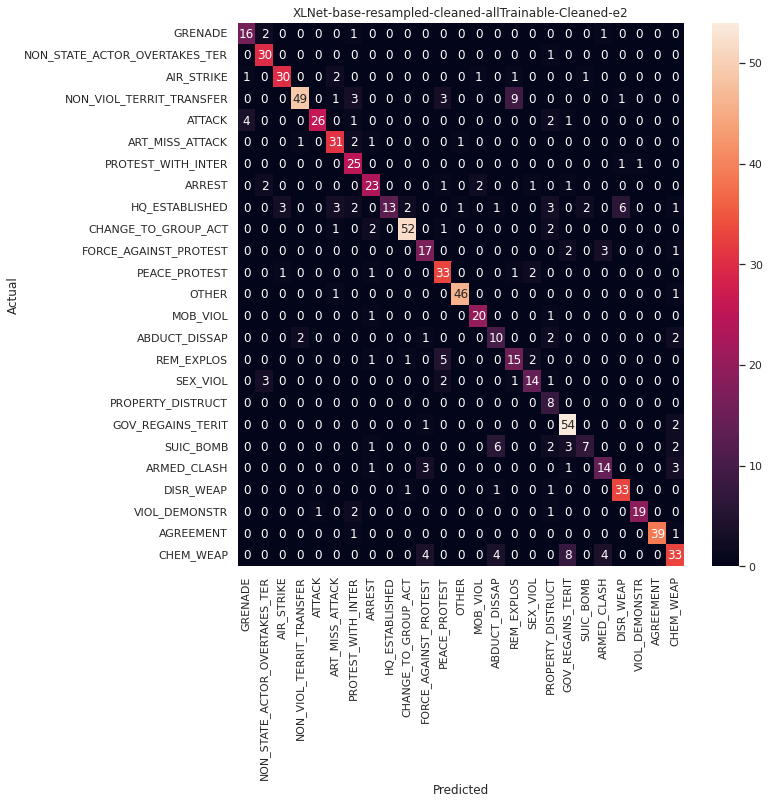

In [72]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(list(test_file.SubType), list(test_file['text-labels-cleaned']))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(test_file.SubType), yticklabels=set(test_file.SubType))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('XLNet-base-resampled-cleaned-allTrainable-Cleaned-e2')
plt.show()

## For lemmatized Text

In [85]:
final_test_inputs, final_test_attention_masks, segments = get_inputs(test_file.lemmatized, tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [86]:
y_preds = np.argmax(model.predict([final_test_inputs, final_test_attention_masks]), axis=1)

In [87]:
y_preds

array([ 4,  8, 15, 23, 24, 10,  1, 12, 12, 18,  9,  3,  1, 14, 20,  2, 18,
        8,  6,  3,  5,  0, 20,  3, 10,  6,  2, 18,  6, 18,  5,  0, 20, 14,
       23, 20, 23, 22, 23, 16, 11,  0, 22, 18, 18,  5, 10,  8,  3, 10, 12,
       24, 15, 11, 19, 16, 12, 10, 24, 18, 16, 10, 13,  5, 24,  8,  5, 18,
        8,  6,  7,  1,  4, 20, 17, 12, 15,  2,  2, 21, 20, 20,  1,  3,  0,
        2,  2,  7,  9, 18,  3, 13,  9,  4,  2, 18,  2,  1,  1, 12,  8, 20,
       23,  0,  1,  3,  1,  3,  7,  2, 16,  3, 24, 12, 12,  4, 20, 13,  8,
       23, 10,  6, 11,  8,  6,  0, 13, 14,  1,  5, 21,  0, 13, 14, 23,  5,
        0, 16, 11, 14,  1,  6,  6,  0,  4,  0, 18,  1,  3, 23,  5, 13, 23,
       23, 16, 14, 21, 13, 12, 12, 18, 14,  3, 18,  3,  0, 11, 15,  9, 18,
       11, 18,  5, 15, 23,  1,  1, 13, 10, 11, 18,  3, 11, 11,  1, 20, 22,
        5, 13, 20, 10, 11, 22, 15,  2, 22,  8, 20, 14,  3, 11, 22, 22, 11,
        7, 11, 17,  0, 15, 20, 12,  7,  2,  0, 12, 16, 16,  7, 17,  3,  1,
        1,  1,  5,  5, 22

In [88]:
test_file['pred-labels-lemmatized'] = y_preds

In [89]:
test_file.head()

,EventSnippet,SubType,processed,lemmatized,pred-labels-cleaned,text-labels-cleaned,pred-labels-lemmatized
id,,,,,,,
1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,the us warplanes pounded the village of kashka...,u warplane pounded village kashkash southern p...,4,AIR_STRIKE,4
3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officers brutally attacked and injured a peace...,officer brutally attacked injured peaceful stu...,8,FORCE_AGAINST_PROTEST,8
4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isis fighters recaptured the village of kashma...,isi fighter recaptured village kashma syrian a...,12,GOV_REGAINS_TERIT,15
5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike pence said thursday that t...,vice-president mike penny said thursday mainly...,23,AGREEMENT,23
6,A helicopter on Thursday is said to have dropp...,CHEM_WEAP,a helicopter thursday is said to have dropped ...,helicopter thursday said dropped container tox...,24,CHEM_WEAP,24


In [90]:
def num_to_text_labels(num):
    text = event_types_dict_inverse[num]
    return text

test_file['text-labels-lemmatized'] = test_file['pred-labels-lemmatized'].apply(num_to_text_labels)

In [91]:
test_file.head()

,EventSnippet,SubType,processed,lemmatized,pred-labels-cleaned,text-labels-cleaned,pred-labels-lemmatized,text-labels-lemmatized
id,,,,,,,,
1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,the us warplanes pounded the village of kashka...,u warplane pounded village kashkash southern p...,4,AIR_STRIKE,4,AIR_STRIKE
3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officers brutally attacked and injured a peace...,officer brutally attacked injured peaceful stu...,8,FORCE_AGAINST_PROTEST,8,FORCE_AGAINST_PROTEST
4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isis fighters recaptured the village of kashma...,isi fighter recaptured village kashma syrian a...,12,GOV_REGAINS_TERIT,15,NON_STATE_ACTOR_OVERTAKES_TER
5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike pence said thursday that t...,vice-president mike penny said thursday mainly...,23,AGREEMENT,23,AGREEMENT
6,A helicopter on Thursday is said to have dropp...,CHEM_WEAP,a helicopter thursday is said to have dropped ...,helicopter thursday said dropped container tox...,24,CHEM_WEAP,24,CHEM_WEAP


In [92]:
test_file.to_csv('results-XLNet-trained-base-resampled-cleaned-epoch-2.csv', index=True)

In [93]:

from sklearn.metrics import classification_report

print(classification_report(y_true= list(test_file.SubType), y_pred= list(test_file['text-labels-lemmatized'])))

                               precision    recall  f1-score   support

                ABDUCT_DISSAP       0.64      0.80      0.71        20
                    AGREEMENT       0.86      0.97      0.91        31
                   AIR_STRIKE       0.85      0.78      0.81        36
                  ARMED_CLASH       0.84      0.71      0.77        66
                       ARREST       0.81      0.74      0.77        34
              ART_MISS_ATTACK       0.69      0.81      0.74        36
                       ATTACK       0.59      0.89      0.71        27
          CHANGE_TO_GROUP_ACT       0.79      0.87      0.83        30
                    CHEM_WEAP       0.88      0.38      0.53        37
                    DISR_WEAP       0.92      0.81      0.86        58
        FORCE_AGAINST_PROTEST       0.59      0.70      0.64        23
            GOV_REGAINS_TERIT       0.79      0.82      0.81        38
                      GRENADE       0.96      0.94      0.95        48
     

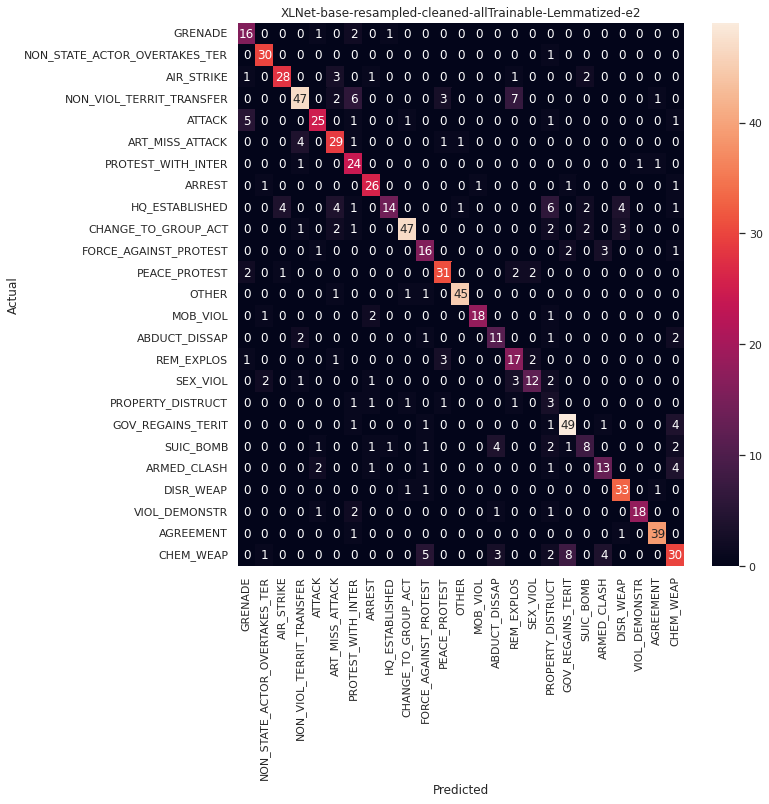

In [94]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix( list(test_file.SubType), list(test_file['text-labels-lemmatized']))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(test_file.SubType), yticklabels=set(test_file.SubType))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('XLNet-base-resampled-cleaned-allTrainable-Lemmatized-e2')
plt.show()

# Epoch - 1

In [97]:
model.load_weights('/content/drive/MyDrive/Shared Task 2021/XLNet-base.h5')

In [98]:
test_file = pd.read_csv('/content/drive/MyDrive/Shared Task 2021/test-set-with-labels-cleaned.txt', index_col=0)

In [99]:
test_file.head()

,EventSnippet,SubType,processed,lemmatized
id,,,,
1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,the us warplanes pounded the village of kashka...,u warplane pounded village kashkash southern p...
3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officers brutally attacked and injured a peace...,officer brutally attacked injured peaceful stu...
4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isis fighters recaptured the village of kashma...,isi fighter recaptured village kashma syrian a...
5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike pence said thursday that t...,vice-president mike penny said thursday mainly...
6,A helicopter on Thursday is said to have dropp...,CHEM_WEAP,a helicopter thursday is said to have dropped ...,helicopter thursday said dropped container tox...


## For Cleaned Text

In [101]:
final_test_inputs, final_test_attention_masks, segments = get_inputs(list(test_file.processed), tokenizer=tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [102]:
y_preds = np.argmax(model.predict([final_test_inputs, final_test_attention_masks]), axis=1)

In [103]:
y_preds

array([ 4,  8, 12, 19, 14, 10,  1, 12, 12, 18, 10, 10,  1, 14, 20,  2, 18,
        8,  6,  3,  5,  0, 20,  3, 10,  6,  2, 18,  6, 18,  5,  0, 20, 14,
       23, 20, 14, 22, 23, 16, 11, 18, 22, 18, 18,  5, 19,  8, 17, 10, 12,
       10, 15, 11, 19, 16, 19, 17, 24, 18, 16, 10, 13,  5,  9,  2,  5, 18,
        6, 17,  7,  1,  4, 20, 17, 12, 15,  8,  2, 21, 20, 20,  1,  3,  5,
        2,  2,  7, 10, 18, 17, 13,  9,  4,  8, 18,  2,  1,  2, 12,  8, 20,
       23,  0,  2, 18,  1,  3,  7,  2, 16,  5, 19, 12, 12,  4, 20, 13,  8,
       23,  6, 10, 18,  8,  6, 14, 13, 14,  1, 18, 21,  0, 13, 12, 10,  5,
        0, 16, 11, 14,  1,  6,  6,  0,  4,  0,  9, 10, 11, 23,  5, 13, 23,
       23, 16, 14, 21, 13, 12, 12, 18, 14,  3, 18,  3,  0, 11, 19,  4, 18,
       18, 18,  5, 19, 21,  1,  1, 12, 23, 11, 18,  8, 11, 10,  2, 20, 22,
        5, 16, 20, 10, 24, 22, 15,  6, 22,  8, 20, 14,  3, 18, 22, 22, 11,
        8, 11, 17,  4, 15, 20, 10,  2,  1, 12, 15, 16,  7,  7, 17,  3,  1,
        1,  1,  6,  5, 22

In [104]:
test_file['pred-labels-cleaned'] = y_preds

In [105]:
test_file.head()

,EventSnippet,SubType,processed,lemmatized,pred-labels-cleaned
id,,,,,
1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,the us warplanes pounded the village of kashka...,u warplane pounded village kashkash southern p...,4
3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officers brutally attacked and injured a peace...,officer brutally attacked injured peaceful stu...,8
4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isis fighters recaptured the village of kashma...,isi fighter recaptured village kashma syrian a...,12
5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike pence said thursday that t...,vice-president mike penny said thursday mainly...,19
6,A helicopter on Thursday is said to have dropp...,CHEM_WEAP,a helicopter thursday is said to have dropped ...,helicopter thursday said dropped container tox...,14


In [106]:
def num_to_text_labels(num):
    text = event_types_dict_inverse[num]
    return text

test_file['text-labels-cleaned'] = test_file['pred-labels-cleaned'].apply(num_to_text_labels)

In [107]:
test_file.head()

,EventSnippet,SubType,processed,lemmatized,pred-labels-cleaned,text-labels-cleaned
id,,,,,,
1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,the us warplanes pounded the village of kashka...,u warplane pounded village kashkash southern p...,4,AIR_STRIKE
3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officers brutally attacked and injured a peace...,officer brutally attacked injured peaceful stu...,8,FORCE_AGAINST_PROTEST
4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isis fighters recaptured the village of kashma...,isi fighter recaptured village kashma syrian a...,12,GOV_REGAINS_TERIT
5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike pence said thursday that t...,vice-president mike penny said thursday mainly...,19,NON_VIOL_TERRIT_TRANSFER
6,A helicopter on Thursday is said to have dropp...,CHEM_WEAP,a helicopter thursday is said to have dropped ...,helicopter thursday said dropped container tox...,14,CHANGE_TO_GROUP_ACT


### **classification_report**

In [108]:

from sklearn.metrics import classification_report

print(classification_report(y_true= list(test_file.SubType), y_pred= list(test_file['text-labels-cleaned'])))

                               precision    recall  f1-score   support

                ABDUCT_DISSAP       0.94      0.75      0.83        20
                    AGREEMENT       0.90      0.87      0.89        31
                   AIR_STRIKE       0.89      0.92      0.90        36
                  ARMED_CLASH       0.89      0.73      0.80        66
                       ARREST       0.91      0.94      0.93        34
              ART_MISS_ATTACK       0.91      0.81      0.85        36
                       ATTACK       0.81      0.78      0.79        27
          CHANGE_TO_GROUP_ACT       0.75      0.80      0.77        30
                    CHEM_WEAP       1.00      0.38      0.55        37
                    DISR_WEAP       0.83      0.95      0.89        58
        FORCE_AGAINST_PROTEST       0.55      0.74      0.63        23
            GOV_REGAINS_TERIT       0.73      0.71      0.72        38
                      GRENADE       0.98      0.98      0.98        48
     

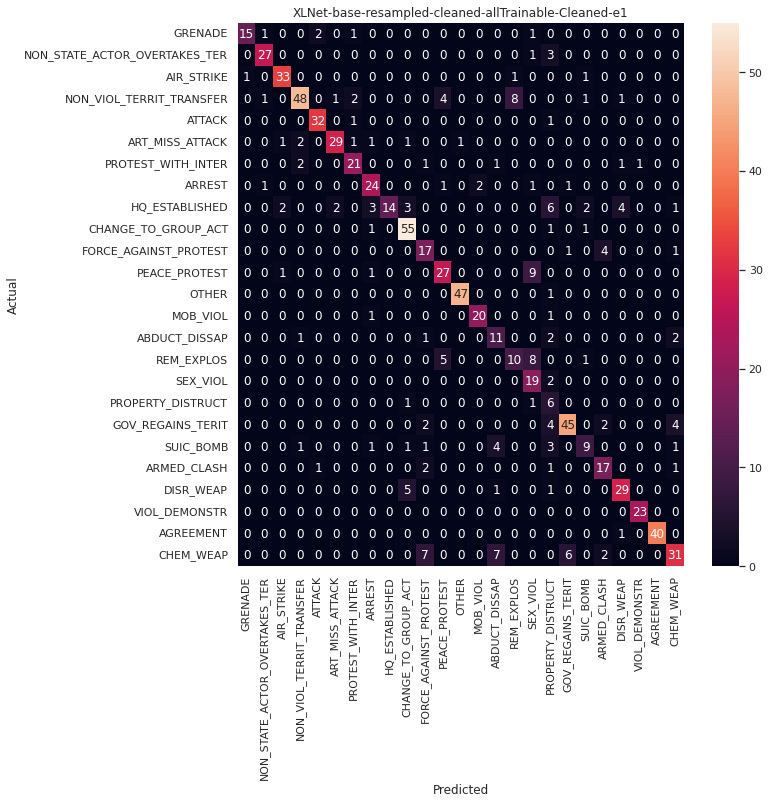

In [109]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(list(test_file.SubType), list(test_file['text-labels-cleaned']))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(test_file.SubType), yticklabels=set(test_file.SubType))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('XLNet-base-resampled-cleaned-allTrainable-Cleaned-e1')
plt.show()

## For lemmatized Text

In [111]:
final_test_inputs, final_test_attention_masks, segments = get_inputs(list(test_file.lemmatized), tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [112]:
y_preds = np.argmax(model.predict([final_test_inputs, final_test_attention_masks]), axis=1)

In [113]:
y_preds

array([ 4,  8, 12, 23, 24, 18,  1, 12, 12, 18,  9,  3,  1, 14, 20,  2, 18,
        8,  6,  3,  5,  0, 20,  3, 10, 17,  7, 18,  6, 18,  5,  0, 20, 14,
       23, 20, 14, 22, 23, 16, 11, 11, 22, 18, 18,  5, 19,  8, 17, 14, 12,
       10, 15, 11, 19, 16, 19, 17, 24, 18, 16, 10, 13,  5,  9,  8,  5, 18,
        6, 17,  7,  1,  4, 20, 17, 12, 15,  7,  8, 21, 20, 20,  1,  3,  0,
        2,  2,  7, 10, 18,  3, 13,  9,  4,  2, 18,  7,  7,  2, 12,  8, 20,
       23,  0,  1,  9,  1,  3,  7,  2, 16,  5, 10, 12, 12,  4, 20,  5,  8,
       23,  9,  6, 18,  8,  6,  0, 13, 14,  1,  5, 21,  0, 13, 12, 10,  5,
        0, 16, 11, 14,  1,  6,  6,  0,  4,  0, 18, 10,  3, 23,  5, 13, 23,
       23, 16, 14, 21, 13, 12, 19, 18, 14,  3, 18,  3,  0, 11, 19,  4, 18,
       11, 18,  5, 15, 21,  1,  7, 12, 10, 11, 18,  3, 11,  9,  1, 20, 22,
        5, 16, 20, 10, 24, 22, 19,  2, 22,  8, 20, 14, 15, 18, 22, 22, 11,
        7, 11, 17,  4, 15, 20, 12,  7,  2, 12, 15, 16,  7,  7, 17,  3,  1,
        1,  1,  5,  5, 22

In [114]:
test_file['pred-labels-lemmatized'] = y_preds

In [115]:
test_file.head()

,EventSnippet,SubType,processed,lemmatized,pred-labels-cleaned,text-labels-cleaned,pred-labels-lemmatized
id,,,,,,,
1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,the us warplanes pounded the village of kashka...,u warplane pounded village kashkash southern p...,4,AIR_STRIKE,4
3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officers brutally attacked and injured a peace...,officer brutally attacked injured peaceful stu...,8,FORCE_AGAINST_PROTEST,8
4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isis fighters recaptured the village of kashma...,isi fighter recaptured village kashma syrian a...,12,GOV_REGAINS_TERIT,12
5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike pence said thursday that t...,vice-president mike penny said thursday mainly...,19,NON_VIOL_TERRIT_TRANSFER,23
6,A helicopter on Thursday is said to have dropp...,CHEM_WEAP,a helicopter thursday is said to have dropped ...,helicopter thursday said dropped container tox...,14,CHANGE_TO_GROUP_ACT,24


In [116]:
def num_to_text_labels(num):
    text = event_types_dict_inverse[num]
    return text

test_file['text-labels-lemmatized'] = test_file['pred-labels-lemmatized'].apply(num_to_text_labels)

In [117]:
test_file.head()

,EventSnippet,SubType,processed,lemmatized,pred-labels-cleaned,text-labels-cleaned,pred-labels-lemmatized,text-labels-lemmatized
id,,,,,,,,
1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,the us warplanes pounded the village of kashka...,u warplane pounded village kashkash southern p...,4,AIR_STRIKE,4,AIR_STRIKE
3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officers brutally attacked and injured a peace...,officer brutally attacked injured peaceful stu...,8,FORCE_AGAINST_PROTEST,8,FORCE_AGAINST_PROTEST
4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isis fighters recaptured the village of kashma...,isi fighter recaptured village kashma syrian a...,12,GOV_REGAINS_TERIT,12,GOV_REGAINS_TERIT
5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike pence said thursday that t...,vice-president mike penny said thursday mainly...,19,NON_VIOL_TERRIT_TRANSFER,23,AGREEMENT
6,A helicopter on Thursday is said to have dropp...,CHEM_WEAP,a helicopter thursday is said to have dropped ...,helicopter thursday said dropped container tox...,14,CHANGE_TO_GROUP_ACT,24,CHEM_WEAP


In [118]:
test_file.to_csv('results-XLNet-trained-base-resampled-cleaned-epoch-1.csv', index=True)

### **classification_report**

In [119]:

from sklearn.metrics import classification_report

print(classification_report(y_true= list(test_file.SubType), y_pred= list(test_file['text-labels-lemmatized'])))

                               precision    recall  f1-score   support

                ABDUCT_DISSAP       1.00      0.75      0.86        20
                    AGREEMENT       0.97      0.90      0.93        31
                   AIR_STRIKE       0.81      0.83      0.82        36
                  ARMED_CLASH       0.84      0.74      0.79        66
                       ARREST       0.91      0.85      0.88        34
              ART_MISS_ATTACK       0.78      0.89      0.83        36
                       ATTACK       0.77      0.85      0.81        27
          CHANGE_TO_GROUP_ACT       0.73      0.80      0.76        30
                    CHEM_WEAP       1.00      0.32      0.49        37
                    DISR_WEAP       0.91      0.90      0.90        58
        FORCE_AGAINST_PROTEST       0.57      0.74      0.64        23
            GOV_REGAINS_TERIT       0.62      0.61      0.61        38
                      GRENADE       0.94      0.98      0.96        48
     

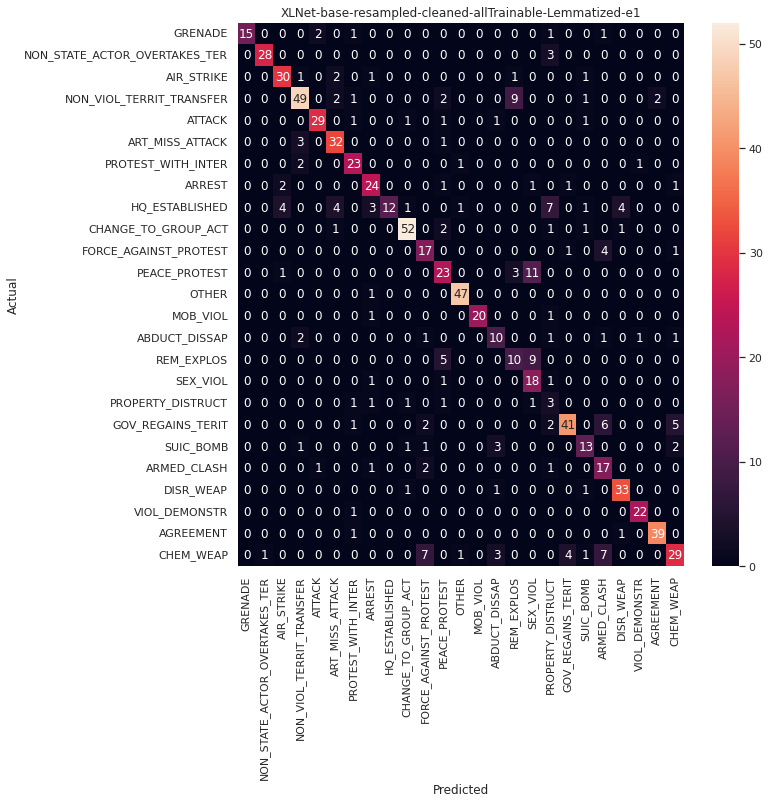

In [120]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix( list(test_file.SubType), list(test_file['text-labels-lemmatized']))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(test_file.SubType), yticklabels=set(test_file.SubType))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('XLNet-base-resampled-cleaned-allTrainable-Lemmatized-e1')
plt.show()